神经网络模型的效果以及优化目标是通过损失函数(loss function)来定义。<br/>
## 经典损失函数
分类问题和回归问题是监督学习的两大分类。通过神经网络解决多分类问题最常见的方法是设置n个输出节点，其中n是类别的个数。对于每个样例，神经网络会得到一个n维的数组作为结果输出，数组的每个维度对应一个类别。在理想情况下，如果一个样本属于类别$k$，那么类别输出数组所对应的数值应该为1，其余数值为0。而`交叉熵(cross entropy)`是衡量输出向量和期望向量相似度的最常用评判方法之一。交叉熵刻画了两个概率分布之间的距离，是分类问题使用比较广的损失函数。<br/>
给定$p$和$q$两个概率分布，通过$q$来表示$p$的交叉熵为：<br/>
$$H(p,q) = -\sum_{x}p(x)logq(x)$$
交叉熵刻画的是两个概率分布之间的距离，然而神经网络的输出并不一定是一个概率分布，而`Softmax回归`是将神经网络前向传播得到的结果变成概率分布。`Softmax回归`可以作为一个学习算法来优化分类结果，但在TensorFlow中，Softmax回归的参数被去掉了，只作为一个额外的处理层，将神经网络的输出变成一个概率分布。<br/>
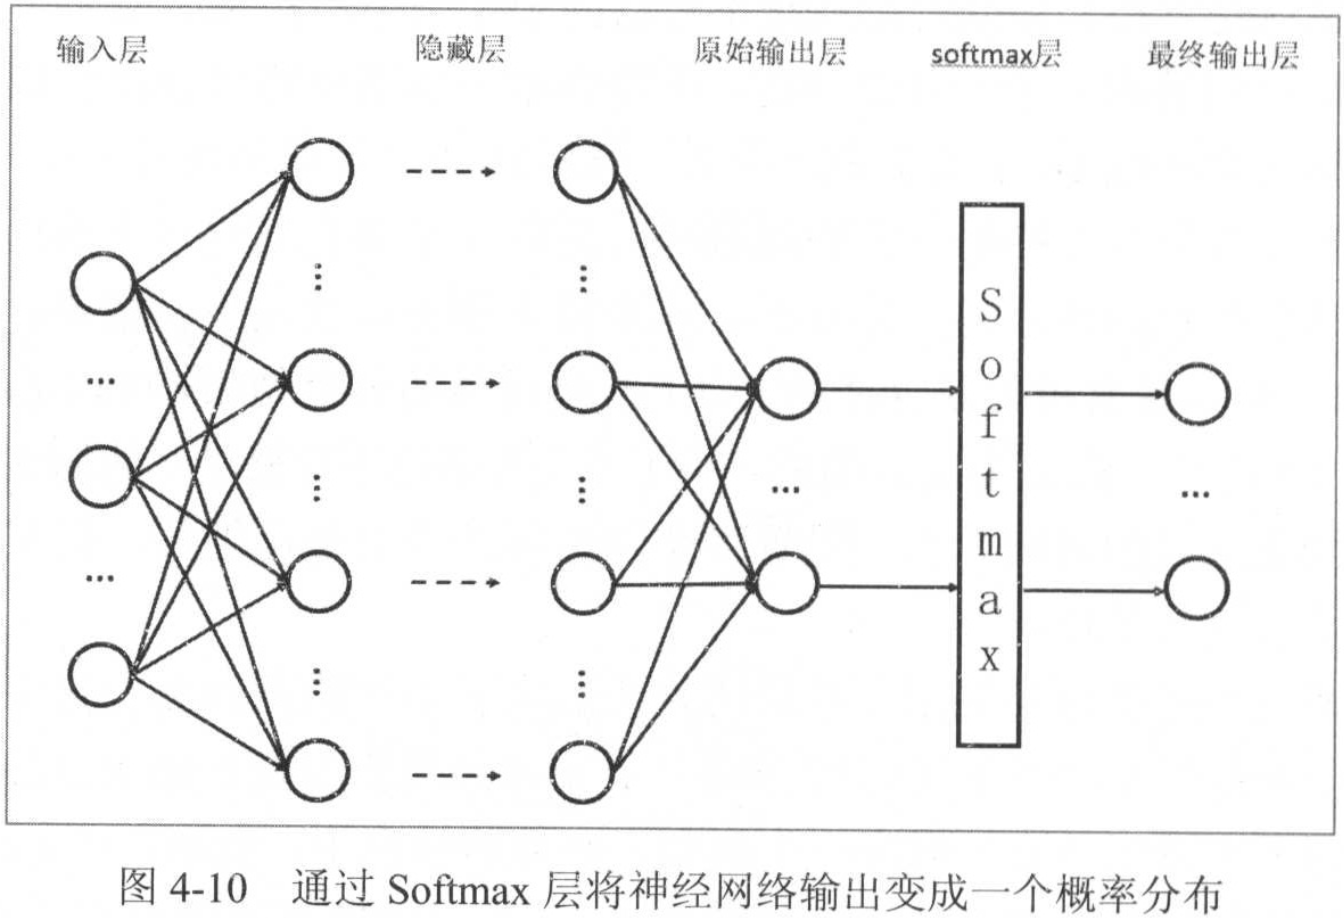
假设原始神经网络的输出为$y_1, y_2, y_3, \cdots, y_n$，那么Softmax回归处理后的输出为：<br/>
$$Softmax(y)_i = y_i^{'} = \frac{e^{yi}}{\sum_{j=1}^{n}e^{yj}}$$
原始神经网络的输出被用作置信度来生成新的输出，新的输出满足概率分布的所有要求，可以理解为经过神经网络的推导，一个样例为不同类别的概率分别为多大。这样就将神经网络的输出也变成了概率分布，从而通过交叉熵来计算预测的概率分布与真实的概率分布之间的距离。<br/>
从交叉熵的公式可以看出交叉熵不是对称的($H(p,q) \neq H(q,p)$)，当交叉熵作为神经网络的损失函数时，p代表真实值，q代表预测值。交叉熵刻画的是两个概率分布的距离，因此值越小，两个概率分布越接近。<br/>
TensorFlow交叉熵部分代码实现如下：

In [ ]:
cross_entropy=-tf.reduce_mean(y_*tf.log(tf.clip_by_value(y, 1e-10, 1.0)))

其中$y\_$代表正确结果，$y$代表预测结果。通过`tf.clip_by_value(y, 1e-10, 1.0)`函数可以将一个tensor中的数值限制在一个范围之内，这样可以避免一些运算错误(比如log0是无效的)。<br/>
使用tf.clip_by_value的简单示例：<br/>

In [2]:
import tensorflow as tf

v = tf.constant([1.0, 2.0, 3.0])
sess = tf.Session()
with sess.as_default():
    print(tf.clip_by_value(v, 2.0, 5.0).eval())

[2. 2. 3.]


根据交叉熵公式，应该将每行中的m个结果相加得到所有样例的交叉熵，然后再对这n行取平均得到一个batch的平均交叉熵。但因为分类问题的类别数量是不变的，所以可以直接对整个矩阵做平均而不改变计算结果的意义。<br/>
因为交叉熵和Softmax回归经常一起使用，所以TensorFlow将这个两个功能封装在一起，并提供`tf.nn.softmax_cross_entropy_with_logits`函数，通过函数的调用可以得到使用Softmax回归之后的交叉熵。TensorFlow还提供了`tf.nn.spare_softmax_cross_entropy_with_logits`函数来进一步加速计算过程。<br/>
**softmax_cross_entropy_with_logits和spare_softmax_cross_entropy_with_logits异同点：**<br/>
- **共同点**：softmax_cross_entropy_with_logits和spare_softmax_cross_entropy_with_logits的输入都需要unscaled logit，因为TensorFlow内部机制会将其进行归一化操作以提高效率。就是说计算loss的时候，不要将输出的类别值进行softmax归一化操作，输入就是wT∗X+b的结果。为什么能提高效率？简单理解就是把unscaled logit输入到softmax loss中在反向传播计算倒数时计算量更少。
- **不同点**:
 1. softmax_cross_entropy_with_logits：使用实数来表示类别，数据类型为int16, int32和int64，标签范围为[0, num_classes-1]，标签维度为[batch_size]大小。
 2. spare_softmax_cross_entropy_with_logits：使用**one-hot**来表示类别，数据类型为float16, float32和float64，维度为[batch_size, num_classes]。

使用Softmax回归之后交叉熵损失函数：<br/>

In [ ]:
# y:原始网络输出结果，y_:样例真实值
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(label=y_, logits=y)

与分类问题不同，解决回归问题的神经网络一般只有一个输出节点，这个节点的输出值就是预测值。对于回归问题，最常用的损失函数是均方误差(MSE, mean squared error)，定义如下：<br/>
$$MSE(y,y^{'})=\frac{\sum_{i=1}^{n}(y_i-y_i^{'})^2}{n}$$
其中$y_i$为一个batch中第i个数据的正确答案，而$y_i^{'}$为神经网络给出的预测值。<br/>
TensorFlow实现均方误差损失函数：<br/>

In [ ]:
# y：神经网络的输出答案，y_代表样例真实值
mse = tf.reduce_mean(tf.square(y_-y))

## 自定义损失函数
TensorFlow不仅支持经典的损失函数，也可以自己定义损失函数。<br/>

In [6]:
import tensorflow as tf
from numpy.random import RandomState
# 定义batch的大小
batch_size = 8

# 定义输入节点
x = tf.placeholder(tf.float32, shape=(None, 2), name="x-input")
# 定义输出节点
y_ = tf.placeholder(tf.float32, shape=(None, 1), name="y-output")
# 定义神经网络模型节点连接参数
w1 = tf.Variable(tf.random_normal([2, 1], stddev=1, seed=1))
y = tf.matmul(x, w1)

# 自定义损失函数
loss_less = 10
loss_more = 1
loss = tf.reduce_sum(tf.where(tf.greater(y, y_), 
                              (y - y_) * loss_more,
                             (y_ - y) * loss_less))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

# 随机生成数据集
rdm = RandomState(1)
dataset_size = 128
X = rdm.rand(dataset_size, 2)
Y = [[x1+x2+rdm.rand()/10.0-0.05] for (x1, x2) in X]

# 训练神经网络
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    STEPS = 5000
    for i in range(STEPS):
        start = (i * batch_size) % dataset_size
        end = min(start + batch_size, dataset_size)
        sess.run(train_step, feed_dict={x: X[start:end], y_: Y[start:end]})
    print(sess.run(w1))

[[1.019347 ]
 [1.0428089]]
